In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pykitti
from scipy.spatial.transform import Rotation as R
from scipy import signal
from scipy.signal import lfilter
import sys
sys.path.append('../')
from vo_funcs import VisualOdometry
from tqdm import tqdm
DATA_DIR = '../data' 
degree = 30
R_oxts_cam = np.array(R.from_euler('z', degree, degrees=True).as_matrix())
%matplotlib inline

In [2]:
def load_data(date, drive):
    data = pykitti.raw(DATA_DIR, date, drive)
    return data

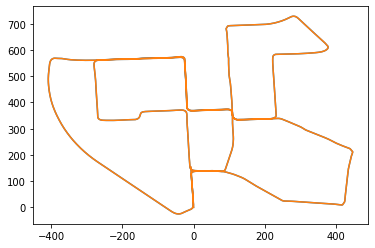

In [3]:
data = load_data('2011_10_03', '0027')
# data = load_data('2011_09_26', '0001')
x, y, z = [], [], []
x_imu = []
y_imu = []
dt = 0.1
R, t_start = pykitti.utils.pose_from_oxts_packet(data.oxts[0].packet, scale=1)
# t_start = R_oxts_cam @ t_start
for i in range(len(data.timestamps)):
    R, t = pykitti.utils.pose_from_oxts_packet(data.oxts[i].packet, scale=1)
    t -= t_start
    t = R_oxts_cam @ t
    x_vel = data.oxts[i].packet.ve
    y_vel = data.oxts[i].packet.vn
    x_vel, y_vel, z_vel = R_oxts_cam @ np.array([x_vel, y_vel, 0])
    x_acc = data.oxts[i].packet.ax
    y_acc = data.oxts[i].packet.ay
    # print(t)
    if len(x_imu) == 0:
        x_imu.append(0)
        y_imu.append(0)
    else:
        x_imu.append(t[0]+x_vel*dt) #+0.5*x_acc*dt**2)
        y_imu.append(t[1]+y_vel*dt) #+0.5*y_acc*dt**2)
        # x_imu.append(x_imu[i-1]+0.5*x_acc*dt**2)
        # y_imu.append(y_imu[i-1]+0.5*y_acc*dt**2)
    x.append(t[0])
    y.append(t[1])
    z.append(t[2])
# plt.axes(projection='3d')
# plt.plot(x[:50])
# plt.plot(x_imu[:200], y_imu[:200])
plt.plot(x, y)
plt.plot(x_imu, y_imu)
plt.show()

In [4]:
print(len(data.oxts))
print(len(data.cam0_files))

4544
4544


In [5]:
print([ i.packet.vn for i in data.oxts[:10]])

[5.91181523139241, 5.99993947855496, 6.0880637257175, 6.17618797288005, 6.2643122200426, 6.35243646720515, 6.4405607143677, 6.52868496153025, 6.6168092086928, 6.70493345585535]


In [6]:
print(np.array(x[1:10])-np.array(x[:9]))

[-0.05440029 -0.05440036 -0.05440044 -0.05440051 -0.05440059 -0.05440066
 -0.05440074 -0.05440081 -0.05440088]


In [7]:
print([ i.packet.au*0.1 for i in data.oxts[:10]])

[1.3026404235734301, 1.2818228622644852, 1.2610053009555402, 1.2401877396465952, 1.21937017833765, 1.198552617028705, 1.1777350557197601, 1.1569174944108152, 1.13609993310187, 1.115282371792925]


In [54]:
class SensorFusion():
    def __init__(self, start_state, data: pykitti.raw, cutout_region=list(range(80,150)), use_smoothing=False):
        # Input Data
        self.data = data
        _, self.t_start = pykitti.utils.pose_from_oxts_packet(data.oxts[0].packet, scale=1)
        self.vo = VisualOdometry(data)

        # Kalman States
        self.state = start_state
        self.pred_state = start_state

        # Simulation cutout
        self.cutout_region = cutout_region
        self.cutout_var = 10
        # History info
        self.pose_est = [self.state]
        self.pose_gt = [self.getGPS(0)]
        self.pose_gt_w_cutout = [self.getGPS(0)[:2]]
        self.pose_vo = [self.getGPS(0)]
        self.K_hist = []

        # Setting up smoothing
        self.use_smoothing = use_smoothing
        self.define_lfilter_vals()
        
    def getOXTSMeasurement(self, index, H):
        t = self.getGPS(index)

        x, y, z = t[:3]
        x_vel = self.data.oxts[index].packet.ve
        y_vel = self.data.oxts[index].packet.vn
        z_vel = self.data.oxts[index].packet.vu
        x_vel, y_vel, z_vel = R_oxts_cam @ np.array([x_vel, y_vel, z_vel])
        # print("OXTS vel", x_vel)
        pos_uncertainty = self.data.oxts[index].packet.pos_accuracy
        vel_uncertainty = self.data.oxts[index].packet.vel_accuracy

        if index in self.cutout_region:
            pos_uncertainty = self.cutout_var # meters
            x = x + np.random.normal(0, pos_uncertainty)
            y = y + np.random.normal(0, pos_uncertainty)
        
        R = np.diag([pos_uncertainty**2, pos_uncertainty**2, vel_uncertainty**2, vel_uncertainty**2])

        return H @ np.array([x, y, x_vel, y_vel]), R

    def getGPS(self, index):
        R, t = pykitti.utils.pose_from_oxts_packet(self.data.oxts[index].packet, scale=1)
        t -= self.t_start
        t = R_oxts_cam @ t
        return t

    def setCutout(self, startInd, endInd):
        self.cutout_region = list(range(startInd, endInd))

    def setCutoutVar(self, var):
        self.cutout_var = var

    # ---Smoothing---
    def define_lfilter_vals(self):
        self.lfilter_b = [signal.firwin(8, 0.004), signal.firwin(8, 0.004)]
        self.lfilter_z = [np.zeros(self.lfilter_b[0].size-1), np.zeros(self.lfilter_b[1].size-1)]

    def get_smoothed_est(self, x, i):
        new_x, self.lfilter_z[0] = signal.lfilter(self.lfilter_b[0], 1, [x[0]], zi=self.lfilter_z[0])
        new_y, self.lfilter_z[1] = signal.lfilter(self.lfilter_b[1], 1, [x[1]], zi=self.lfilter_z[1])
        # if i in self.cutout_region:
        if len(self.pose_est) > self.lfilter_b[0].size:
            x[0] = new_x
            x[1] = new_y
        return x

    # ---Kalman Filter---
    def predict(self, A, B, u, P, Q):
        predicted_X = A @ self.state + B @ u
        predicted_P = A @ P @ A.T + Q
        return predicted_X, predicted_P

    def calc_gain(self, P, H, R):
        numerator = P@H.T
        denominator = H@P@H.T + R
        K = numerator/denominator
        # print(K)
        K = np.diag(np.diag(K))
        # K[0,1] = 0
        # K[1,0] = 0
        return K

    def update(self, K, z, H, P):
        # print(K)
        updated_X = self.pred_state + K @ (z - H@self.pred_state)
        n = len(K@H)
        updated_P = (np.eye(n)-K@H)@P
        return updated_X, updated_P
        
    def run(self, A, B, P, Q, H, n_iter=-1):
        dt = 0.1
        for i, gt_pose in enumerate(tqdm(self.vo.gt_poses[:n_iter], unit="poses")):
            # Get VO control input velocity
            if i < 1:
                cur_pose = self.vo.gt_poses[0]
                delta_x = cur_pose[0, 3]
                delta_y = cur_pose[2, 3]
                self.pose_vo.append(cur_pose[:3,3])
            else:
                transf = self.vo.get_pose(i)
                old_pose = np.copy(cur_pose)
                cur_pose = np.matmul(cur_pose, transf)
                self.pose_vo.append(1.5*cur_pose[:3,3])
                # print(cur_pose)
                delta_x, delta_z, delta_y = 1.5*(cur_pose[:3, 3] - (old_pose[:3, 3]))
            x_vo_velocity = delta_x/dt
            y_vo_velocity = delta_y/dt
            # print("X_vel", x_vo_velocity)
            # print(x_vo_velocity, self.data.oxts[i].packet.vf, self.data.oxts[i].packet.vl)
            u = np.array([ 
                0,
                0,
                x_vo_velocity, #+ 0.2*self.data.oxts[i].packet.vn
                y_vo_velocity
            ])
            # print("Iteration", i)
            #
            self.pred_state, predicted_P = self.predict(A, B, u, P, Q)
            z, R = self.getOXTSMeasurement(i, H)
            self.pose_gt_w_cutout.append(z[:2])
            K = self.calc_gain(predicted_P, H, R)

            # print("z:", z, "predicted_X", self.pred_state)

            self.state, P = self.update(K, z, H, predicted_P)
            if self.use_smoothing:
                self.state = self.get_smoothed_est(self.state, i)
            # print("Update_x:", self.state, "GT:", self.getGPS(i))
            
            self.pose_est.append(self.state)
            gt_t = gt_pose[:3, 3]
            gt_t = R_oxts_cam @ gt_t
            self.pose_gt.append(gt_t)
            # self.pose_gt.append(self.getGPS(i))
        self.pose_est = np.array(self.pose_est)
        self.pose_gt = np.array(self.pose_gt)
        self.pose_vo = np.array(self.pose_vo)
        self.pose_gt_w_cutout = np.array(self.pose_gt_w_cutout)
    def plot_res(self, vis_cutout):
        if vis_cutout:
            plt.plot(self.pose_gt_w_cutout[:,0], self.pose_gt_w_cutout[:,1], label="GT_w_cutout", color='red')
        plt.plot(self.pose_est[:,0], self.pose_est[:,1], label="KF Estimates", color='blue')
        plt.plot(self.pose_gt[:,0], self.pose_gt[:,1], label="GT", color='orange')
        plt.plot(self.pose_vo[:,0], self.pose_vo[:,2], label="VO", color='green')
        plt.legend()
        plt.show()
    def get_metrics(self):
        avg_error = np.mean(self.pose_est[:,0]-self.pose_gt[:,0])
        print(f"Average Error: {avg_error}")
        avg_cutout_error = np.sum(np.array([x[0] for x in self.pose_est[self.cutout_region]]) - np.array([x[0] for x in self.pose_gt[self.cutout_region]]))/len(self.cutout_region)
        print(f"Average Error in cutout: {avg_cutout_error}")
        return avg_error

    def run_default(self, n_iter=-1):
        dt = 0.1
        A = np.array([
            [1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        B = np.array([ 
            [0, 0, dt, 0],
            [0, 0, 0, dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        A[:,2:] *=0.5
        B[:,2:] *=0.5

        P = np.diag([10,10,10,10])
        Q = np.diag([1,1,1,1])
        H = np.diag([1,1,1,1])
        self.run(A, B, P, Q, H, n_iter)

In [55]:
data = load_data('2011_10_03', '0027')
# data = load_data('2011_09_26', '0001')

start_vec = np.array([0, 0, 0, 0])
positions = []
gt_positions = []
kf = SensorFusion(start_vec, data)
kf.setCutout(80,150)
kf.setCutoutVar(10)
n_iter = 200
kf.run_default(n_iter)

  0%|          | 0/200 [00:00<?, ?poses/s]C:\Users\Bhargav\AppData\Local\Temp\ipykernel_13088\555812184.py:82: RuntimeWarning: invalid value encountered in true_divide
  K = numerator/denominator
100%|██████████| 200/200 [01:28<00:00,  2.26poses/s]


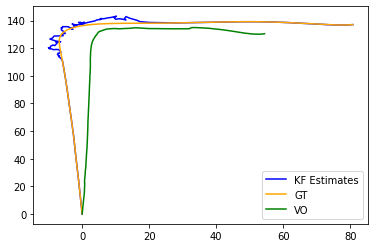

In [56]:
kf.plot_res(False)


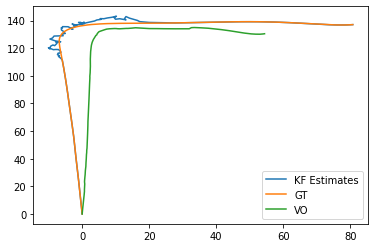

In [57]:
plt.plot(kf.pose_est[:,0], kf.pose_est[:,1], label="KF Estimates")
plt.plot(kf.pose_gt[:,0], kf.pose_gt[:,1], label="GT")
plt.plot(kf.pose_vo[:,0], kf.pose_vo[:,2], label="VO")
# plt.plot(kf.pose_gt_w_cutout[:,0], kf.pose_gt_w_cutout[:,1], label="GT_w_cutout")
plt.legend()
plt.show()

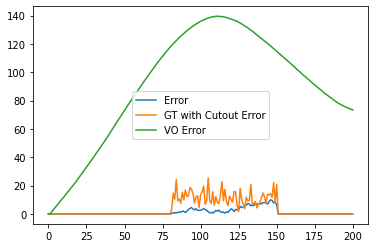

In [58]:
plt.plot(np.sqrt(np.abs(kf.pose_gt[:,0]-kf.pose_est[:,0])**2+np.abs(kf.pose_gt[:,1]-kf.pose_est[:,1])**2), label="Error")
plt.plot(np.sqrt(np.abs(kf.pose_gt_w_cutout[:,0]-kf.pose_est[:,0])**2+np.abs(kf.pose_gt_w_cutout[:,1]-kf.pose_est[:,1])**2), label="GT with Cutout Error")
plt.plot(np.sqrt(np.abs(kf.pose_gt[:1000,0]-kf.pose_vo[:,0])**2+np.abs(kf.pose_gt[:1000,1]-kf.pose_vo[:,1])**2), label="VO Error")

plt.legend()
plt.show()

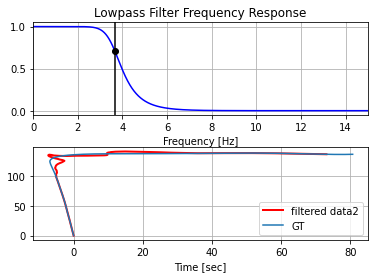

In [15]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from numpy import zeros

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Setting standard filter requirements.
order = 6
fs = 30.0       
cutoff = 3.667  

b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Creating the data for filteration
T = 1.0         # value taken in seconds
n = int(T * fs) # indicates total samples
t = np.linspace(0, T, n, endpoint=False)

# data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)
data = kf.pose_gt_w_cutout[:,0]
datay = kf.pose_gt_w_cutout[:,1]

# Filtering and plotting
# y = butter_lowpass_filter(data, cutoff, fs, order)
b = signal.firwin(20, 0.0004)
z = zeros(b.size-1)
z2 = z.copy()
result1 = np.zeros(len(data))
result2 = np.zeros(len(data))
for i, (x, y) in enumerate(zip(data, datay)):
    result1[i], z = signal.lfilter(b, 1, [x], zi=z)
    result2[i], z2 = signal.lfilter(b, 1, [y], zi=z2)

plt.subplot(2, 1, 2)
# plt.plot(data,datay, 'b-', label='data')
# plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.plot(result1, result2, 'r-', linewidth=2, label='filtered data2')
plt.plot(kf.pose_gt[:,0], kf.pose_gt[:,1], label="GT")
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

In [16]:
from scipy import signal, random
from numpy import zeros

def filter_sbs(data, b):
    z = zeros(b.size-1)
    result = zeros(data.size)
    for i, x in enumerate(data):
        result[i], z = signal.lfilter(b, 1, [x], zi=z)
    return result
    
def filter(data, b):
    result = signal.lfilter(b,1,data)
    return result

if __name__ == '__main__':
    data = random.random(20000)
    
    b = signal.firwin(150, 0.004)
    result1 = filter_sbs(data, b)
    result2 = filter(data, b)
    print(result1 - result2)
    plt.plot(data, label=)
    plt.plot(result1)
    plt.show()

SyntaxError: invalid syntax (2374862444.py, line 22)

In [ ]:
%matplotlib inline